In [1]:
# plotting
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# numeric
import quandl
import numpy as np
from numpy import random
import pandas as pd

# util
from collections import Counter
import pdb
import time
import tempfile
import itertools
from tqdm import tqdm_notebook as tqdm
import datetime

# logging
import logging
logger = log = logging.getLogger(__name__)
# log.setLevel(logging.INFO)
logging.basicConfig()
log.info('%s logger started.', __name__)

In [2]:
import gym
from gym import error, spaces, utils
from gym.utils import seeding

In [3]:
import os
os.sys.path.append(os.path.abspath('.'))
%reload_ext autoreload
%autoreload 2

In [19]:
# params
window_length = 50

save_path = './outputs/tensorforce-VPG/tensorforce-VPG_20170717_04-42-55.model'
save_path

'./outputs/tensorforce-VPG/tensorforce-VPG_20170717_04-42-55.model'

# Enviroment

In [5]:
from src.environments.portfolio import PortfolioEnv

In [6]:
from rl.memory import  SequentialMemory, Memory
from collections import deque

class EnvWrapper(PortfolioEnv):
    """Wraps env to normalise and reshape action."""
    def __init__(self, window_length=50, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def step(self, action):
        # also it puts it in a list
        if isinstance(action, list):
            action = action[0]
        
        # we have to normalise for some reason softmax wont work
        if isinstance(action, dict):
            action = np.abs(list(action.values()))
            action /= action.sum()        
        
        return super().step(action) 

In [7]:
df_train = pd.read_hdf('./data/poloniex_30m.hf',key='train')
env = EnvWrapper(
    df=df_train,
    steps=30, 
    scale=True, 
    augment=0.000,
    trading_cost=0, # let just overfit first,
    window_length = window_length,
    
)
env.seed = 0   

df_test = pd.read_hdf('./data/poloniex_30m.hf',key='test')
env_test = EnvWrapper(
    df=df_test,
    steps=30, 
    scale=True, 
    augment=0.00,
    trading_cost=0, # let just overfit first
    window_length=window_length,
)
env_test.seed = 0  

from tensorforce.environments.openai_gym import OpenAIGym
environment = OpenAIGym('CartPole-v0')
environment.gym = env

environment_test = OpenAIGym('CartPole-v0')
environment_test.gym = env_test

INFO:gym.envs.registration:Making new env: CartPole-v0
[2017-07-19 07:33:56,754] Making new env: CartPole-v0
INFO:gym.envs.registration:Making new env: CartPole-v0
[2017-07-19 07:33:56,762] Making new env: CartPole-v0


In [8]:
# check shapes
obs1, reward, done, info=env.step(np.random.random(env.action_space.shape))
print(reward, done, info)
obs2 = env.reset()
print(obs1.shape,obs2.shape)

0.0 False {'reward': 0.0, 'log_return': 0.0, 'portfolio_value': 1.0, 'returns': 1.002080046461342, 'rate_of_return': 0.0, 'cost': 0.0, 'steps': 2}
(5, 50, 3) (5, 50, 3)


# Model

Derived from  https://github.com/reinforceio/tensorforce/blob/0d07fadec03f76537a2431e17c51cd759d53b5e9/tensorforce/core/networks/layers.py#L90

In [9]:
from tensorforce import Configuration
from tensorforce.agents import VPGAgent
from tensorforce.core.networks import layered_network_builder

In [10]:
# layer helpers from:
# https://github.com/reinforceio/tensorforce/blob/0d07fadec03f76537a2431e17c51cd759d53b5e9/tensorforce/core/networks/layers.py#L90
import tensorflow as tf
from math import sqrt
from tensorforce import util
from tensorforce import TensorForceError

def linear(x, size, bias=True, l2_regularization=0.0):
    if util.rank(x) != 2:
        raise TensorForceError('Invalid input rank for linear layer.')
    with tf.variable_scope('linear'):
        weights = tf.Variable(initial_value=tf.random_normal(shape=(x.get_shape()[1].value, size), stddev=sqrt(2.0 / (x.get_shape()[1].value + size))))
        if l2_regularization > 0.0:
            tf.losses.add_loss(l2_regularization * tf.nn.l2_loss(t=weights))
        x = tf.matmul(a=x, b=weights)
        if bias:
            bias = tf.Variable(initial_value=tf.zeros(shape=(size,)))
            if l2_regularization > 0.0:
                tf.losses.add_loss(l2_regularization * tf.nn.l2_loss(t=bias))
            x = tf.nn.bias_add(value=x, bias=bias)
    return x

def nonlinearity(x, name='relu'):
    with tf.variable_scope('nonlinearity'):
        if name == 'elu':
            x = tf.nn.elu(features=x)
        elif name == 'relu':
            x = tf.nn.relu(features=x)
        elif name == 'selu':
            # https://arxiv.org/pdf/1706.02515.pdf
            alpha = 1.6732632423543772848170429916717
            scale = 1.0507009873554804934193349852946
            negative = alpha * tf.nn.elu(features=x)
            x = scale * tf.where(condition=(x >= 0.0), x=x, y=negative)
        elif name == 'sigmoid':
            x = tf.sigmoid(x=x)
        elif name == 'softmax':
            x = tf.nn.softmax(logits=x)
        elif name == 'tanh':
            x = tf.nn.tanh(x=x)
        else:
            raise TensorForceError('Invalid nonlinearity.')
    return x

def dense(x, size, bias=True, activation='relu', l2_regularization=0.0):
    if util.rank(x) != 2:
        raise TensorForceError('Invalid input rank for dense layer.')
    with tf.variable_scope('dense'):
        x = linear(x=x, size=size, bias=bias, l2_regularization=l2_regularization)
        x = nonlinearity(x=x, name=activation)
    return x

def flatten(x):
    with tf.variable_scope('flatten'):
        x = tf.reshape(tensor=x, shape=(-1, util.prod(x.get_shape().as_list()[1:])))
    return x

def conv2d(x, size, window=(3,3), stride=(1,1), bias=False, activation='relu', l2_regularization=0.0, padding='SAME'):
    if util.rank(x) != 4:
        raise TensorForceError('Invalid input rank for conv2d layer.')
    with tf.variable_scope('conv2d'):
        filters = tf.Variable(initial_value=tf.random_normal(shape=(window[0], window[1], x.get_shape()[3].value, size), stddev=sqrt(2.0 / size)))
        if l2_regularization > 0.0:
            tf.losses.add_loss(l2_regularization * tf.nn.l2_loss(t=filters))
        x = tf.nn.conv2d(input=x, filter=filters, strides=(1, stride[0], stride[1], 1), padding=padding)
        if bias:
            bias = tf.Variable(initial_value=tf.zeros(shape=(size,)))
            if l2_regularization > 0.0:
                tf.losses.add_loss(l2_regularization * tf.nn.l2_loss(t=bias))
            x = tf.nn.bias_add(value=x, bias=bias)
        x = nonlinearity(x=x, name=activation)
    return x


In [11]:
# build a network for a given input
def network_builder(inputs):
    if len(inputs) != 1:
        raise TensorForceError('Layered network must have only one input.')
    x = next(iter(inputs.values()))
    
    x = conv2d(x=x, size=2, window=(1,3), bias=True, activation='relu', l2_regularization=1e-8, padding='VALID')
    x = conv2d(x=x, size=20, window=(1,window_length-2), bias=True, activation='relu', l2_regularization=1e-8, padding='VALID')
    x = conv2d(x=x, size=1, window=(1,1), bias=True, activation='relu', l2_regularization=1e-8, padding='VALID')
    x = flatten(x)
    x = dense(x, size=env.action_space.shape[0],activation='relu', l2_regularization=1e-8)
    x = nonlinearity(x,name='softmax')
    
    return x
network=network_builder

# Agent

In [12]:
config = Configuration(   
    # Each model requires the following configuration parameters:
    discount=0,  # float of discount factor (gamma).
    learning_rate=3e-5,  # float of learning rate (alpha).
    optimizer='adam',  # string of optimizer to use (e.g. 'adam').
#     optimizer_args= ,  # list of arguments for optimizer.
#     optimizer_kwargs= ,  # dict of keyword arguments for optimizer.
#     device= ,  # string of tensorflow device name.
    tf_saver=True,  # boolean whether to save model parameters.
#     tf_summary= ,  # boolean indicating whether to use tensorflow summary file writer.
    log_level='info',  # string containing logleve (e.g. 'info').
    distributed=False ,  # boolean indicating whether to use distributed tensorflow.
#     global_model= ,  # global model.
#     session= ,  # session to use.
    
    # Each agent requires the following ``Configuration`` parameters:
    network=network,
    states=dict(shape=tuple(env.observation_space.shape), type='float'),
    actions={'action' + str(n): dict(continuous=True) for n in range(env.action_space.shape[0])},
    preprocessing = None,# dict or list containing state preprocessing configuration.
    exploration = dict(
        type='EpsilonDecay',
        kwargs=dict(epsilon=1, epsilon_final=0.01, epsilon_timesteps=1e4)
    ),

    # The `BatchAgent` class additionally requires the following parameters:
    batch_size = 50,# integer of the batch size.

    # A Policy Gradient Model expects the following additional configuration parameters:
    sample_actions= True,# boolean of whether to sample actions.
#     baseline='mlp' ,# string indicating the baseline value function (currently 'linear' or 'mlp').
#     baseline_args=dict(size=100, repeat_update=100) ,# list of arguments for the baseline value function.
    override_line_search=False,
    
#     baseline_kwargs= ,# dict of keyword arguments for the baseline value function.
    generalized_advantage_estimation= True ,# boolean indicating whether to use GAE.
    gae_lambda= 0.97,# float of the Generalized Advantage Estimation lambda.
    normalize_advantage= False,# boolean indicating whether to normalize the advantage or not.
    cg_iterations=20,
    max_kl_divergence=0.005,
    cg_damping=0.001,
    line_search_steps=20,
    loglevel="info",
)

# Create a Trust Region Policy Optimization agent
agent = VPGAgent(config=config)

# Train

In [13]:
def sharpe(returns, freq=30, rfr=0):
    """Given a set of returns, calculates naive (rfr=0) sharpe (eq 28) """
    return (np.sqrt(freq) * np.mean(returns-rfr)) / np.std(returns - rfr)

def MDD(returns):
    """Max drawdown."""
    peak = returns.max()
    i = returns.argmax()
    trough = returns[returns.argmax():].min()
    return (trough-peak)/trough 

In [28]:
# Callback function printing episode statistics
class EpisodeFinished(object):
    """Logger callback for tensorforce runner"""
    
    def __init__(self, log_intv):
        self.log_intv = log_intv
        self.portfolio_values = [] 
        self.mdds=[]
        self.sharpes=[]
    
    def __call__(self, r):
        if len(r.environment.gym.sim.infos):
            self.portfolio_values.append(r.environment.gym.sim.infos[-1]['portfolio_value'])
            
            df = pd.DataFrame(r.environment.gym.sim.infos)
            self.mdds.append(MDD(df.rate_of_return+1))
            self.sharpes.append(sharpe(df.rate_of_return+1))
        if r.episode % self.log_intv == 0:
            print(
                "Finished episode {ep} after {ts} timesteps (reward: {reward: 2.4f} [{rewards_min: 2.4f}, {rewards_max: 2.4f}]) portfolio_value: {portfolio_value: 2.4f} [{portfolio_value_min: 2.4f}, {portfolio_value_max: 2.4f}] mdd={mdd: 2.2%} sharpe={sharpe: 2.2f}".
                format(
                    ep=r.episode,
                    ts=r.timestep,
                    reward=np.mean(r.episode_rewards[-self.log_intv:]),
                    rewards_min=np.min(r.episode_rewards[-self.log_intv:]),
                    rewards_max=np.max(r.episode_rewards[-self.log_intv:]),
                    portfolio_value=np.mean(self.portfolio_values[-self.log_intv:]),
                    portfolio_value_min=np.min(self.portfolio_values[-self.log_intv:]),
                    portfolio_value_max=np.max(self.portfolio_values[-self.log_intv:]),
                    mdd=np.mean(self.mdds[-self.log_intv:]),
                    sharpe=np.mean(self.sharpes[-self.log_intv:]),
                )
            )
        return True

In [15]:
# Callback EpisodeFinishedTQDM
from tqdm import tqdm_notebook
class EpisodeFinishedTQDM(EpisodeFinished):
    """Logger for tensorforce using tqdm_notebook for jupyter-notebook."""
    
    def __init__(self, episodes, log_intv):
        """
        log_intv - print the mean metrics every log_intv episodes
        """
        super().__init__(log_intv=log_intv)
        self.episodes = episodes
        self.progbar = tqdm_notebook(desc='', 
                                     total=episodes, 
                                     leave=True, mininterval=5)
    
    def __call__(self, r):
        super().__call__(r)
        desc = "reward: {reward: 2.4f} [{rewards_min: 2.4f}, {rewards_max: 2.4f}], portfolio_value: {portfolio_value: 2.4f} [{portfolio_value_min: 2.4f}, {portfolio_value_max: 2.4f}]".        format(
            reward=np.mean(r.episode_rewards[-1:]),
            rewards_min=np.min(r.episode_rewards[-1:]),
            rewards_max=np.max(r.episode_rewards[-1:]),
            portfolio_value=np.mean(self.portfolio_values[-1:]),
            portfolio_value_min=np.min(self.portfolio_values[-1:]),
            portfolio_value_max=np.max(self.portfolio_values[-1:])
        )
        self.progbar.desc = desc
        self.progbar.update(1)  # update
        return True

In [16]:
from tensorforce.execution import Runner
runner = Runner(agent=agent, environment=environment, save_path=save_path, save_episodes=10000)

In [20]:
agent.load_model(save_path)

INFO:tensorflow:Restoring parameters from ./outputs/tensorforce-VPG/tensorforce-VPG_20170717_04-42-55.model


INFO:tensorflow:Restoring parameters from ./outputs/tensorforce-VPG/tensorforce-VPG_20170717_04-42-55.model
[2017-07-19 07:35:58,198] Restoring parameters from ./outputs/tensorforce-VPG/tensorforce-VPG_20170717_04-42-55.model


In [29]:
runner.run(
    episodes=2e6, max_timesteps=200, episode_finished=EpisodeFinishedTQDM(log_intv=1000, episodes=2e6))

Finished episode 1000 after 30 timesteps (reward:  0.0003 [-0.0034,  0.0062]) portfolio_value:  1.0089 [ 0.9031,  1.2030]
Finished episode 2000 after 30 timesteps (reward:  0.0002 [-0.0033,  0.0031]) portfolio_value:  1.0071 [ 0.9063,  1.0977]
Finished episode 3000 after 30 timesteps (reward:  0.0002 [-0.0054,  0.0060]) portfolio_value:  1.0068 [ 0.8503,  1.1988]
Finished episode 4000 after 30 timesteps (reward:  0.0003 [-0.0069,  0.0036]) portfolio_value:  1.0090 [ 0.8120,  1.1129]
Finished episode 5000 after 30 timesteps (reward:  0.0003 [-0.0042,  0.0042]) portfolio_value:  1.0082 [ 0.8827,  1.1359]
Finished episode 6000 after 30 timesteps (reward:  0.0003 [-0.0029,  0.0044]) portfolio_value:  1.0084 [ 0.9167,  1.1396]
Finished episode 7000 after 30 timesteps (reward:  0.0002 [-0.0039,  0.0067]) portfolio_value:  1.0062 [ 0.8884,  1.2209]
Finished episode 8000 after 30 timesteps (reward:  0.0002 [-0.0186,  0.0041]) portfolio_value:  1.0077 [ 0.5715,  1.1307]
Finished episode 9000 af

Finished episode 67000 after 30 timesteps (reward:  0.0003 [-0.0040,  0.0044]) portfolio_value:  1.0083 [ 0.8858,  1.1395]
Finished episode 68000 after 30 timesteps (reward:  0.0002 [-0.0070,  0.0045]) portfolio_value:  1.0061 [ 0.8096,  1.1429]
Finished episode 69000 after 30 timesteps (reward:  0.0002 [-0.0081,  0.0038]) portfolio_value:  1.0077 [ 0.7849,  1.1209]
Saving agent after episode 70000
Finished episode 70000 after 30 timesteps (reward:  0.0002 [-0.0040,  0.0055]) portfolio_value:  1.0073 [ 0.8867,  1.1801]
Finished episode 71000 after 30 timesteps (reward:  0.0002 [-0.0028,  0.0048]) portfolio_value:  1.0074 [ 0.9198,  1.1562]
Finished episode 72000 after 30 timesteps (reward:  0.0002 [-0.0046,  0.0065]) portfolio_value:  1.0074 [ 0.8712,  1.2163]
Finished episode 73000 after 30 timesteps (reward:  0.0003 [-0.0039,  0.0036]) portfolio_value:  1.0082 [ 0.8893,  1.1153]
Finished episode 74000 after 30 timesteps (reward:  0.0002 [-0.0038,  0.0048]) portfolio_value:  1.0072 [ 

Finished episode 132000 after 30 timesteps (reward:  0.0002 [-0.0041,  0.0052]) portfolio_value:  1.0076 [ 0.8855,  1.1687]
Finished episode 133000 after 30 timesteps (reward:  0.0003 [-0.0071,  0.0057]) portfolio_value:  1.0087 [ 0.8086,  1.1879]
Finished episode 134000 after 30 timesteps (reward:  0.0002 [-0.0033,  0.0052]) portfolio_value:  1.0076 [ 0.9059,  1.1695]
Finished episode 135000 after 30 timesteps (reward:  0.0002 [-0.0047,  0.0045]) portfolio_value:  1.0080 [ 0.8688,  1.1441]
Finished episode 136000 after 30 timesteps (reward:  0.0002 [-0.0148,  0.0048]) portfolio_value:  1.0062 [ 0.6414,  1.1549]
Finished episode 137000 after 30 timesteps (reward:  0.0003 [-0.0042,  0.0057]) portfolio_value:  1.0081 [ 0.8826,  1.1863]
Finished episode 138000 after 30 timesteps (reward:  0.0002 [-0.0092,  0.0060]) portfolio_value:  1.0068 [ 0.7591,  1.1973]
Finished episode 139000 after 30 timesteps (reward:  0.0002 [-0.0032,  0.0035]) portfolio_value:  1.0075 [ 0.9072,  1.1101]
Saving a

Finished episode 197000 after 30 timesteps (reward:  0.0002 [-0.0038,  0.0041]) portfolio_value:  1.0073 [ 0.8910,  1.1296]
Finished episode 198000 after 30 timesteps (reward:  0.0002 [-0.0172,  0.0046]) portfolio_value:  1.0077 [ 0.5962,  1.1463]
Finished episode 199000 after 30 timesteps (reward:  0.0002 [-0.0027,  0.0035]) portfolio_value:  1.0072 [ 0.9222,  1.1109]
Saving agent after episode 200000
Finished episode 200000 after 30 timesteps (reward:  0.0002 [-0.0058,  0.0041]) portfolio_value:  1.0072 [ 0.8414,  1.1313]
Finished episode 201000 after 30 timesteps (reward:  0.0002 [-0.0045,  0.0044]) portfolio_value:  1.0079 [ 0.8738,  1.1417]
Finished episode 202000 after 30 timesteps (reward:  0.0002 [-0.0032,  0.0055]) portfolio_value:  1.0080 [ 0.9088,  1.1783]
Finished episode 203000 after 30 timesteps (reward:  0.0002 [-0.0057,  0.0041]) portfolio_value:  1.0059 [ 0.8440,  1.1308]
Finished episode 204000 after 30 timesteps (reward:  0.0002 [-0.0058,  0.0079]) portfolio_value:  

Finished episode 262000 after 30 timesteps (reward:  0.0002 [-0.0079,  0.0043]) portfolio_value:  1.0059 [ 0.7892,  1.1391]
Finished episode 263000 after 30 timesteps (reward:  0.0003 [-0.0045,  0.0045]) portfolio_value:  1.0081 [ 0.8742,  1.1458]
Finished episode 264000 after 30 timesteps (reward:  0.0002 [-0.0038,  0.0033]) portfolio_value:  1.0067 [ 0.8920,  1.1054]
Finished episode 265000 after 30 timesteps (reward:  0.0002 [-0.0037,  0.0055]) portfolio_value:  1.0069 [ 0.8962,  1.1781]
Finished episode 266000 after 30 timesteps (reward:  0.0002 [-0.0065,  0.0073]) portfolio_value:  1.0076 [ 0.8231,  1.2440]
Finished episode 267000 after 30 timesteps (reward:  0.0002 [-0.0038,  0.0041]) portfolio_value:  1.0056 [ 0.8921,  1.1293]
Finished episode 268000 after 30 timesteps (reward:  0.0002 [-0.0041,  0.0055]) portfolio_value:  1.0072 [ 0.8847,  1.1782]
Finished episode 269000 after 30 timesteps (reward:  0.0003 [-0.0050,  0.0144]) portfolio_value:  1.0095 [ 0.8615,  1.5384]
Saving a

KeyboardInterrupt: 

In [37]:
# save
agent.save_model(save_path)
save_path

'./outputs/tensorforce-VPG_20170717_04-42-55.model'

# Test

INFO:gym.envs.registration:Making new env: CartPole-v0
[2017-07-19 08:43:41,316] Making new env: CartPole-v0


INFO:tensorflow:Restoring parameters from ./outputs/tensorforce-VPG/tensorforce-VPG_20170717_04-42-55.model


INFO:tensorflow:Restoring parameters from ./outputs/tensorforce-VPG/tensorforce-VPG_20170717_04-42-55.model
[2017-07-19 08:43:41,321] Restoring parameters from ./outputs/tensorforce-VPG/tensorforce-VPG_20170717_04-42-55.model


APV (Accumulated portfolio value): 	 22.95
SR (Sharpe ratio):                 	 621.32
MDD (max drawdown):                	-20.81%



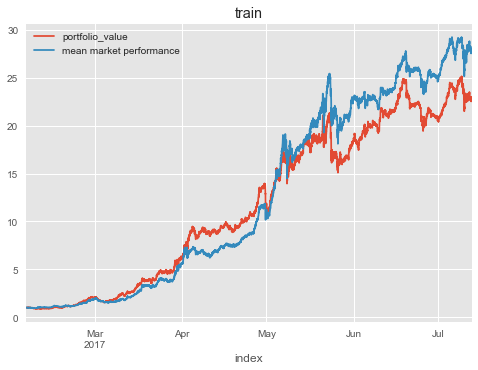

In [118]:
# one big test
df_test = pd.read_hdf('./data/poloniex_30m.hf',key='test')
steps=len(df_test)-window_length-2
env_test = EnvWrapper(
    df=df_test,
    steps=steps, 
    scale=True, 
    augment=0.00,
    trading_cost=0, # let just overfit first
    window_length=window_length,
)
env_test.seed = 0  
environment_test = OpenAIGym('CartPole-v0')
environment_test.gym = env_test

agent.load_model(save_path)
runner_test = Runner(agent=agent, environment=environment_test)
runner_test.run(
episodes=1, max_timesteps=steps, episode_finished=EpisodeFinished(10))

df = pd.DataFrame(env_test.infos)
df.index=df['index']

s=sharpe(df.rate_of_return+1)
mdd=MDD(df.rate_of_return+1)
apv=df.portfolio_value.iloc[-1]
print('APV (Accumulated portfolio value): \t{: 2.2f}'.format(apv))
print('SR (Sharpe ratio):                 \t{: 2.2f}'.format( s))
print('MDD (max drawdown):                \t{: 2.2%}'.format( mdd))
print('')

# show one run vs average market performance
plt.title('test MDD={}, Sharpe={}, APV={}'.format(mdd,s,apv))
df.portfolio_value.plot()
df.mean_market_returns.cumprod().plot(label='mean market performance')
plt.legend()

INFO:tensorflow:Restoring parameters from ./outputs/tensorforce-VPG/tensorforce-VPG_20170717_04-42-55.model


INFO:tensorflow:Restoring parameters from ./outputs/tensorforce-VPG/tensorforce-VPG_20170717_04-42-55.model
[2017-07-19 08:31:39,085] Restoring parameters from ./outputs/tensorforce-VPG/tensorforce-VPG_20170717_04-42-55.model


APV (Accumulated portfolio value): 	 1.00
SR (Sharpe ratio):                 	 809.26
MDD (max drawdown):                	-4.06%

APV (Accumulated portfolio value): 	 1.00
SR (Sharpe ratio):                 	 791.37
MDD (max drawdown):                	-2.51%

APV (Accumulated portfolio value): 	 0.99
SR (Sharpe ratio):                 	 946.75
MDD (max drawdown):                	-2.71%

APV (Accumulated portfolio value): 	 1.01
SR (Sharpe ratio):                 	 999.40
MDD (max drawdown):                	-3.05%

APV (Accumulated portfolio value): 	 1.01
SR (Sharpe ratio):                 	 1216.19
MDD (max drawdown):                	-1.91%

APV (Accumulated portfolio value): 	 0.99
SR (Sharpe ratio):                 	 745.02
MDD (max drawdown):                	-3.63%

APV (Accumulated portfolio value): 	 0.98
SR (Sharpe ratio):                 	 829.13
MDD (max drawdown):                	-3.21%

APV (Accumulated portfolio value): 	 1.01
SR (Sharpe ratio):                 	 715.65
MDD

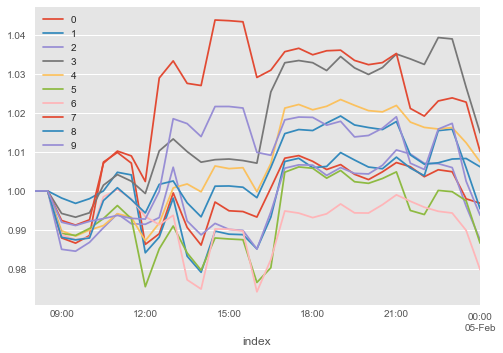

In [114]:
agent.load_model(save_path)
runner_test = Runner(agent=agent, environment=environment_test)
data=[]
for i in range(10):
    environment_test.gym.seed=i
    runner_test.run(
    episodes=2, max_timesteps=32, episode_finished=EpisodeFinished(10))
    df = pd.DataFrame(environment_test.gym.infos)
    df.index=df['index']
    
    s=sharpe(df.rate_of_return+1)
    mdd=MDD(df.rate_of_return+1)
    data.append(dict(sharpe=s,mdd=mdd))
    print('APV (Accumulated portfolio value): \t{: 2.2f}'.format(df.portfolio_value.iloc[-1]))
    print('SR (Sharpe ratio):                 \t{: 2.2f}'.format( s))
    print('MDD (max drawdown):                \t{: 2.2%}'.format( mdd))
    print('')
    df.portfolio_value.plot(label=str(i))
plt.legend()

In [119]:
# one big test over train
# one big test
df_train = pd.read_hdf('./data/poloniex_30m.hf',key='train')
steps=len(df_train)-window_length-2
env = EnvWrapper(
    df=df_train,
    steps=steps, 
    scale=True, 
    augment=0.00,
    trading_cost=0, # let just overfit first
    window_length=window_length,
)
env.seed = 0  
environment = OpenAIGym('CartPole-v0')
environment.gym = env

agent.load_model(save_path)
runner = Runner(agent=agent, environment=environment)
runner.run(
episodes=1, max_timesteps=steps, episode_finished=EpisodeFinished(10))

df = pd.DataFrame(env.infos)
df.index=df['index']

s=sharpe(df.rate_of_return+1)
mdd=MDD(df.rate_of_return+1)
data.append(dict(sharpe=s,mdd=mdd))
print('APV (Accumulated portfolio value): \t{: 2.2f}'.format(df.portfolio_value.iloc[-1]))
print('SR (Sharpe ratio):                 \t{: 2.2f}'.format( s))
print('MDD (max drawdown):                \t{: 2.2%}'.format( mdd))
print('')

# show one run vs average market performance
plt.title('train')
df.portfolio_value.plot()
df.mean_market_returns.cumprod().plot(label='mean market performance')
plt.legend()

INFO:gym.envs.registration:Making new env: CartPole-v0
[2017-07-19 08:44:58,031] Making new env: CartPole-v0


INFO:tensorflow:Restoring parameters from ./outputs/tensorforce-VPG/tensorforce-VPG_20170717_04-42-55.model


INFO:tensorflow:Restoring parameters from ./outputs/tensorforce-VPG/tensorforce-VPG_20170717_04-42-55.model
[2017-07-19 08:44:58,036] Restoring parameters from ./outputs/tensorforce-VPG/tensorforce-VPG_20170717_04-42-55.model


KeyboardInterrupt: 